In [1]:
import pandas as pd 
import numpy as np
import re 
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt 
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 

In [3]:
def linear_func(coef, intercept):
    return lambda x: - (coef[0][0] * x + intercept) / coef[0][1]

In [4]:
# full data for FLU[21, 22, 23, 27] datasets 
flu_data = pd.read_csv('FLU.csv')
# full data for AGE datasets 
age_data = pd.read_csv('AGE.csv')

In [5]:
# filter clusters by size 
valid_flu = flu_data[flu_data['size'] >= 5]
valid_age = age_data[age_data['size'] >= 5]

# and concat datasets 
compilation = pd.concat([valid_age, valid_flu], ignore_index=True)

In [6]:
# find IG and AGE datasets
reg = re.compile('.*_IG_.*')
ig_datasets = filter(reg.match, list(Counter(compilation['dataset'])))
ig_datasets = compilation[compilation['dataset'].isin(ig_datasets)]

reg = re.compile('AGE.*')
age_datasets = filter(reg.match, list(Counter(compilation['dataset'])))
age_datasets = compilation[compilation['dataset'].isin(age_datasets)]

In [7]:
# create feature with absolute second value vote
ig_datasets['second_vote_abs'] = ig_datasets['value1'] * ig_datasets['size']
age_datasets['second_vote_abs'] = age_datasets['value1'] * age_datasets['size']

/home/ndurasov/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ndurasov/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# use only two features
X_ig = scale(ig_datasets[['second_vote_abs', 'size']])
y_ig = ig_datasets['quality_imp']

X_age = scale(age_datasets[['second_vote_abs', 'size']])
y_age  = age_datasets['quality_imp']

In [9]:
# split datasets into train and test
sizes_ig_train, sizes_ig_test, X_ig_train, X_ig_test, y_ig_train, y_ig_test = train_test_split(ig_datasets['size'],
                                                                                               X_ig, 
                                                                                               y_ig, 
                                                                                               test_size = 0.2, 
                                                                                               train_size = 0.8, 
                                                                                               stratify = y_ig)

sizes_age_train, sizes_age_test, X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(age_datasets['size'],
                                                                                                     X_age, 
                                                                                                     y_age, 
                                                                                                     test_size = 0.2, 
                                                                                                     train_size = 0.8, 
                                                                                                     stratify = y_age )

In [10]:
# Logregression for FLU datasets 

cls = LogisticRegression()

gs1 = GridSearchCV(estimator=cls, param_grid={'C': np.linspace(1e-4, 1, 10)}, scoring='roc_auc', 
                   cv=5, fit_params = {'sample_weight': sizes_ig_train})

gs1.fit(X_ig_train, y_ig_train)

print "Training and testing for FLU train datasets. roc-auc:", \
        roc_auc_score(y_ig_train, gs1.best_estimator_.predict_proba(X_ig_train)[:, 1], sample_weight=sizes_ig_train)

print classification_report(y_ig_train, gs1.best_estimator_.predict(X_ig_train), sample_weight=sizes_ig_train)

print "Training and testing for FLU test datasets. roc-auc:", \
        roc_auc_score(y_ig_test, gs1.best_estimator_.predict_proba(X_ig_test)[:, 1], sample_weight=sizes_ig_test)
    
print classification_report(y_ig_test, gs1.best_estimator_.predict(X_ig_test), sample_weight=sizes_ig_test)

print "Training on FLU and testing on AGE datasets. roc-auc:", \
        roc_auc_score(y_age , gs1.best_estimator_.predict_proba(X_age)[:, 1], sample_weight=age_datasets['size'])

print classification_report(y_age, gs1.best_estimator_.predict(X_age), sample_weight=age_datasets['size'])

Training and testing for FLU train datasets. roc-auc: 0.983365551371
             precision    recall  f1-score   support

         -1       0.87      0.96      0.91  728836.0
          1       0.96      0.87      0.91  837008.0

avg / total       0.92      0.91      0.91 1565844.0

Training and testing for FLU test datasets. roc-auc: 0.973532540529
             precision    recall  f1-score   support

         -1       0.87      0.94      0.91  180155.0
          1       0.94      0.86      0.90  180618.0

avg / total       0.90      0.90      0.90  360773.0

Training on FLU and testing on AGE datasets. roc-auc: 0.965662388519
             precision    recall  f1-score   support

         -1       1.00      0.66      0.80 7139596.0
          1       0.19      1.00      0.32  567944.0

avg / total       0.94      0.69      0.76 7707540.0



In [15]:
GridSearchCV?

In [16]:
# Logregression for AGE datasets 

cls = LogisticRegression()

gs2 = GridSearchCV(estimator=cls, param_grid={'C': np.linspace(1e-4, 1, 10)}, scoring='roc_auc', 
                   cv=5, fit_params = {'sample_weight': sizes_age_train}, n_jobs=1)

gs2.fit(X_age_train, y_age_train)

print "Training and testing for AGE train datasets. roc-auc:", \
        roc_auc_score(y_age_train, gs2.best_estimator_.predict_proba(X_age_train)[:, 1], sample_weight=sizes_age_train)

print classification_report(y_age_train, gs2.best_estimator_.predict(X_age_train), sample_weight=sizes_age_train)

print "Training and testing for AGE test datasets. roc-auc:", \
        roc_auc_score(y_age_test, gs2.best_estimator_.predict_proba(X_age_test)[:, 1], sample_weight=sizes_age_test)
    
print classification_report(y_age_test, gs2.best_estimator_.predict(X_age_test), sample_weight=sizes_age_test)

print "Training on AGE and testing on FLU datasets. roc-auc:", \
        roc_auc_score(y_ig, gs1.best_estimator_.predict_proba(X_ig)[:, 1], sample_weight=ig_datasets['size'])

print classification_report(y_ig, gs2.best_estimator_.predict(X_ig), sample_weight=ig_datasets['size'])

Training and testing for AGE train datasets. roc-auc: 0.969930998796
             precision    recall  f1-score   support

         -1       0.95      0.99      0.97 5721219.0
          1       0.76      0.41      0.53  466937.0

avg / total       0.94      0.95      0.94 6188156.0

Training and testing for AGE test datasets. roc-auc: 0.972558591608
             precision    recall  f1-score   support

         -1       0.96      0.99      0.97 1418377.0
          1       0.78      0.40      0.53  101007.0

avg / total       0.95      0.95      0.95 1519384.0

Training on AGE and testing on FLU datasets. roc-auc: 0.981658574656
             precision    recall  f1-score   support

         -1       0.55      1.00      0.71  908991.0
          1       1.00      0.26      0.42 1017626.0

avg / total       0.78      0.61      0.55 1926617.0



(-10, 200)

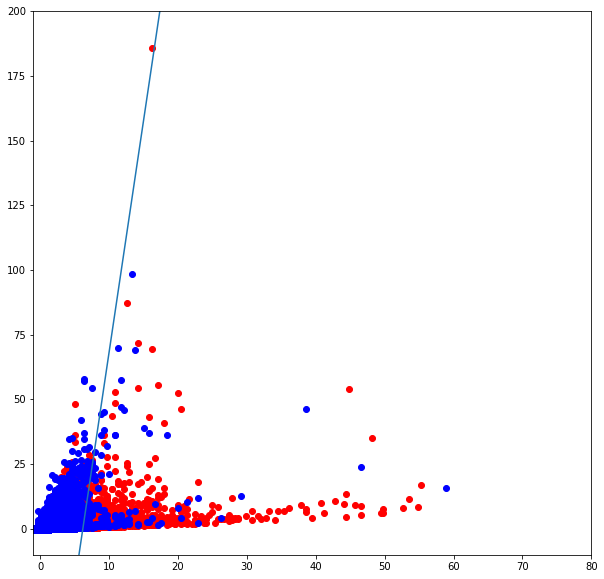

In [17]:
curve = linear_func(gs2.best_estimator_.coef_, gs2.best_estimator_.intercept_)
plt.figure(figsize=(10, 10))

plt.scatter(X_age[y_age == 1][:, 0], X_age[y_age == 1][:, 1], c='r')

plt.scatter(X_age[y_age == -1][:, 0], X_age[y_age == -1][:, 1], c='b')

plt.plot(range(60), [curve(x) for x in range(60)])

plt.xlim((-1, 80))
plt.ylim((-10, 200))

(-10, 200)

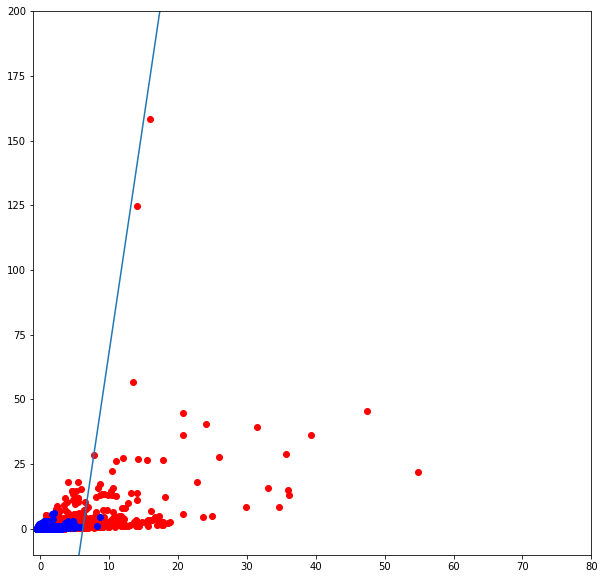

In [12]:
curve = linear_func(gs2.best_estimator_.coef_, gs2.best_estimator_.intercept_)
plt.figure(figsize=(10, 10))

plt.scatter(X_ig[y_ig == 1][:, 0], X_ig[y_ig == 1][:, 1], c='r')

plt.scatter(X_ig[y_ig == -1][:, 0], X_ig[y_ig == -1][:, 1], c='b')

plt.plot(range(60), [curve(x) for x in range(60)])

plt.xlim((-1, 80))
plt.ylim((-10, 200))

In [66]:
# Logregression for mixed datasets 

cls = LogisticRegression()

gs3 = GridSearchCV(estimator=cls, param_grid={'C': np.linspace(1e-4, 1, 10)}, scoring='roc_auc', 
                   cv=5, fit_params={'sample_weight': list(sizes_age_train) + list(sizes_ig_train)})

gs3.fit(np.vstack([X_age_train, X_ig_train]), list(y_age_train) + list(y_ig_train))

print "Training on mixed dataset and testing on AGE datasets. roc-auc:", \
       roc_auc_score(y_age_test, gs3.best_estimator_.predict_proba(X_age_test)[:, 1], sample_weight=sizes_age_test)

print classification_report(y_age_test, gs3.best_estimator_.predict(X_age_test), sample_weight=sizes_age_test)

print "Training on mixed dataset and testing on FLU datasets. roc-auc:", \
       roc_auc_score(y_ig_test, gs3.best_estimator_.predict_proba(X_ig_test)[:, 1], sample_weight=sizes_ig_test)
    
print classification_report(y_ig_test, gs3.best_estimator_.predict(X_ig_test), sample_weight=sizes_ig_test)

 Training on mixed dataset and testing on AGE datasets. roc-auc: 0.970250925568
             precision    recall  f1-score   support

         -1       0.97      0.98      0.97 1423436.0
          1       0.64      0.59      0.61  104367.0

avg / total       0.95      0.95      0.95 1527803.0

Training on mixed dataset and testing on FLU datasets. roc-auc: 0.982827504529
             precision    recall  f1-score   support

         -1       0.59      1.00      0.74  181640.0
          1       0.99      0.36      0.53  197039.0

avg / total       0.80      0.67      0.63  378679.0



(-10, 200)

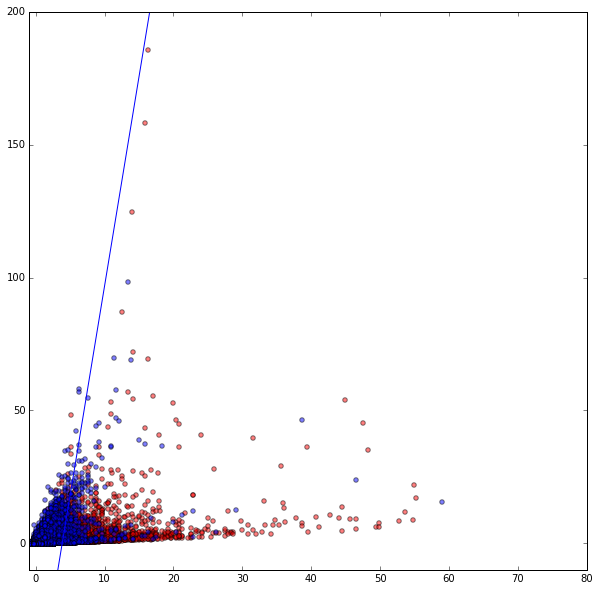

In [41]:
curve = linear_func(gs3.best_estimator_.coef_, gs3.best_estimator_.intercept_)
plt.figure(figsize=(10, 10))

plt.scatter(X_ig[y_ig == 1][:, 0], X_ig[y_ig == 1][:, 1], c='r', alpha=0.5)
plt.scatter(X_ig[y_ig == -1][:, 0], X_ig[y_ig == -1][:, 1], c='b', alpha=0.5)

plt.scatter(X_age[y_age == 1][:, 0], X_age[y_age == 1][:, 1], c='r', alpha=0.5)
plt.scatter(X_age[y_age == -1][:, 0], X_age[y_age == -1][:, 1], c='b', alpha=0.5)

plt.plot(range(60), [curve(x) for x in range(60)])

plt.xlim((-1, 80))
plt.ylim((-10, 200))

In [18]:
t = roc_curve(y_ig_test, gs3.best_estimator_.predict_proba(X_ig_test)[:, 1], sample_weight=sizes_ig_test)
plt.plot(t[0], t[1])

NameError: name 'gs3' is not defined

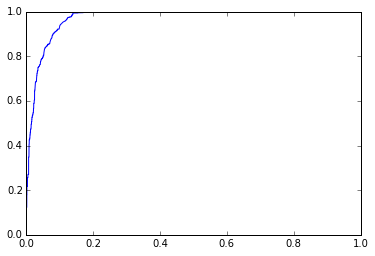

In [52]:
t = roc_curve(y_age_test, gs3.best_estimator_.predict_proba(X_age_test)[:, 1], sample_weight=sizes_age_test)
plt.plot(t[0], t[1])

In [79]:
# Logregression for mixed datasets 

cls = RandomForestClassifier(n_estimators=40)

mixed_sizes = pd.Series(list(sizes_age_train) + list(sizes_ig_train), 
                        index=list(sizes_age_train.index) + list(sizes_ig_train.index))

gs4 = GridSearchCV(estimator=cls, param_grid={'max_depth': range(1, 4, 1)}, scoring='roc_auc', 
                   cv=5, fit_params={'sample_weight': mixed_sizes}, n_jobs=1)

gs4.fit(np.vstack([X_age_train, X_ig_train]), list(y_age_train) + list(y_ig_train))

print "Training on mixed dataset and testing on AGE datasets. roc-auc:", \
       roc_auc_score(y_age_test, gs4.best_estimator_.predict_proba(X_age_test)[:, 1], sample_weight=sizes_age_test)

print classification_report(y_age_test, gs4.best_estimator_.predict(X_age_test), sample_weight=sizes_age_test)

print "Training on mixed dataset and testing on FLU datasets. roc-auc:", \
       roc_auc_score(y_ig_test, gs3.best_estimator_.predict_proba(X_ig_test)[:, 1], sample_weight=sizes_ig_test)
    
print classification_report(y_ig_test, gs4.best_estimator_.predict(X_ig_test), sample_weight=sizes_ig_test)

Training on mixed dataset and testing on AGE datasets. roc-auc: 0.964132787579
             precision    recall  f1-score   support

         -1       0.98      0.95      0.96 1423436.0
          1       0.51      0.78      0.62  104367.0

avg / total       0.95      0.93      0.94 1527803.0

Training on mixed dataset and testing on FLU datasets. roc-auc: 0.982827504529
             precision    recall  f1-score   support

         -1       0.69      0.99      0.81  181640.0
          1       0.98      0.59      0.74  197039.0

avg / total       0.84      0.78      0.77  378679.0

